In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm, uniform
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams['figure.figsize'] = (15,10)

In [3]:
threshold_ = np.load('thres3_1.npy')

In [4]:
upper_, lower_ = threshold_[0][:96], threshold_[1][:96]

In [5]:
start_cost = 3 * 1000 * 16 * 7.6
r = 0.05

def R(ss_t):
    return (ss_t - 5) * 1000 * 16 * 7.6

def Profit(s0, ss0, ss1, upper, lower):
    idx_off = (s0 == 0)
    idx_on = (s0 == 1)

    turn_on = idx_off * (ss0 > upper)
    turn_off = idx_on * (ss0 < lower)

    profit = R(ss1)
    profit[turn_on] = - start_cost
    profit[idx_off & (ss0 <= upper)] = 0

    action = idx_off * (ss0 > upper) + idx_on * (ss0 >= lower)

    return profit, action #action=s1

def valuation(power, gas, upper, lower):#power & gas(10000*97);upper & lower(96)
    ss = (power - 12 * gas)
    n = ss.shape[0]
    N = 2 * 12 * 4 #96
    s = np.zeros((n,N+1))
    V = 0
    for i in range(N): #0-95
        profit, s[:, i+1] = Profit(s[:,i], ss[:,i], ss[:,i+1], upper[i], lower[i])
        V += profit * np.exp(-r*(i+1)/48)
    return np.mean(V)

In [6]:
def cali(Power, Gas, ll = -0.4*10**7, uu = 1.2*10**7, d=10**6):
    V = []
    
    bound_list = np.array([ll + d * (x+1) for x in range(int((uu -ll)/d))])
    combo = [(i,j) for i in bound_list for j in bound_list]
    for i in bound_list :
        for j in bound_list :
            upper = np.ones(96)*i
            lower = np.ones(96)*j
            V.append(valuation(Power, Gas, upper, lower))
    return combo[np.argmax(V)], np.max(V)

In [72]:
Gas = pd.read_csv('Gas_Simulation_97.csv', header=None).T.values
Power = pd.read_csv('Power_Simulation_97.csv', header=None).T.values

In [78]:
valuation(Power, Gas, upper_, lower_)

94756534.35469067

In [74]:
Gas.shape

(10000, 97)

In [21]:
def new_path(eval_para_pos, n = 5000):
#     N_month = 97
    N = 24
    N *= 4
    dt = 1/48
    thetap1 = [39.28, 40.65, 40.48, 42.75, 46.62, 71.88, 86.92, 103.63, 60.78, 35.55, 39.67, 44.47]
    thetag1 = [2.51, 2.49, 2.66, 2.59, 5.28, 6.33, 6.39, 5.93, 3.12, 2.73, 2.02, 3.07]
    p_theta_std = np.array([1.45, 1.92, 2.36, 2.65, 5.01, 8.66, 12.21, 13.79, 12.78, 14.01, 12.77, 10.9])
    g_theta_std = np.array([0.17, 0.2, 0.28, 0.4, 0.43, 0.67, 0.48, 0.53, 0.45, 0.78, 0.84, 0.71])
    variable_list = [7, 20, 3, 75, 0.083, 35, 0, 3, 75, 7.22, 0.3, 28.87, 10.83, np.array(thetap1), np.array(thetag1)]
    variables_names = ['alphaCC', 'alphaJC', 'alphaG', 
                       'm', 'p', 'CC0', 'JC0', 'G0',
                       'spike_thres', 'sigmaG', 'rho', 
                       'v_summer', 'v_winter', 'PowerTheta', 'GasTheta']
    vec_res_p = list()
    vec_res_g = list()
    month_list = [i for i in range(1, 98)]
    num_ses = np.arange(-3, 3.2, 0.2)
    len_muls = len(num_ses)
    result_ = list()
    
    for num_se in num_ses:

        if eval_para_pos == 0:
            new_variable = 7 - num_se * 0.5
        if eval_para_pos == 1:
            new_variable = 20 - num_se * 1.3
        if eval_para_pos == 2:
            new_variable = 3 - num_se * 0.2

        if eval_para_pos == 3:
            new_variable = 75 - num_se * 5
        elif eval_para_pos == 4:
            new_variable = 0.083 - num_se * 0.005
        elif eval_para_pos == 9:
            new_variable = 7.22 - num_se * 0.05
        elif eval_para_pos == 10:
            new_variable = 0.3 - num_se * 0.05
        elif eval_para_pos == 11:
            new_variable = 28.87 - num_se * 2
        elif eval_para_pos == 12:
            new_variable = 10.83 - num_se * 2
        elif eval_para_pos == 13:
            new_variable = variable_list[13] - num_se * p_theta_std 
        elif eval_para_pos == 14:
            new_variable = variable_list[14] - num_se * g_theta_std
        else:
            new_variable = variable_list[eval_para_pos]

        variable_list[eval_para_pos] = new_variable
        alphaCC  = variable_list[0]
        alphaJC  = variable_list[1]
        alphaG  = variable_list[2]
        m  = variable_list[3]
        p  = variable_list[4]
        CC0  = variable_list[5]
        JC0  = variable_list[6]
        G0  = variable_list[7]
        spike_thres  = variable_list[8]
        sigmaG  = variable_list[9]/np.sqrt(dt)/100
        rho  = variable_list[10]
        v_summer  = variable_list[11]/np.sqrt(dt)/100
        v_winter  = variable_list[12]/np.sqrt(dt)/100
        PowerTheta  = variable_list[13]
        GasTheta  = variable_list[14]
        
        
        V = np.zeros((N+1,n))
        W = norm.rvs(size = (N+1,n))*np.sqrt(dt)
        Wtilde = norm.rvs(size = (N+1,n))*np.sqrt(dt)
        B = rho*W + np.sqrt(1-rho**2)*Wtilde
        
#         W = norm.rvs(size = (N+1,n))*np.sqrt(dt)
#         Wtilde = norm.rvs(size = (N+1,n))*np.sqrt(dt)
#         B = rho*W + np.sqrt(1-rho**2)*Wtilde

        CC = np.zeros((N+1,n)) 
        CC[0,:] = CC0
        JC = np.zeros((N+1,n))
        JC[0,:] = JC0
        G = np.zeros((N+1,n)) 
        G[0,:] = G0
        PC = np.zeros((N+1,n))
        PC[0,:] = CC[0,:]
        # 
#         Power_MSE,Gas_MSE = 0, 0
#         Power_Price_Fit, Gas_Price_Fit, CC_Price_Fit, JC_Price_Fit = list(), list(), list(), list()
#         Power_Price_Weekly, Gas_Price_Weekly = list(),list()


        for i in range(1, N + 1):
            month1 = month_list[int(np.ceil(i/4)) - 1] if np.ceil(i/4) <= 12 else month_list[int(np.ceil(i/4)) - 1-12]
            monthIndicator = (month1 > 4)&(month1 < 9)

            V[i,:] = monthIndicator*v_summer + (1 - monthIndicator)*v_winter
            CC[i,:] = alphaCC*(thetap1[month1-1] - CC[i-1,:])*dt + V[i,:]*CC[i-1,:]*W[i,:] + CC[i-1,:]
            JC[i,:] = alphaJC*( 0 - JC[i-1,:])*dt + m*(uniform.rvs() < p)+JC[i-1,:]
            #Power Price
            PC[i,:] = CC[i,:] + JC[i,:]*(PC[i-1,:] > spike_thres)
            #Gas Price
            G[i,:]  = alphaG*(thetag1[month1-1] - G[i-1,:])*dt + sigmaG * G[i-1,:] * B[i,:] + G[i-1,:]
            
        result_.append(valuation(PC.T, G.T, upper_, lower_))
    results = np.array(result_) / result_[int(len_muls / 2)]
    
#     return (variables_names[eval_para_pos], np.mean(np.abs(results - 1)), np.std(np.abs(results - 1)), result_[int(len_muls / 2)])
    return (variables_names[eval_para_pos], np.mean(np.abs(results - 1)))
#     plt.plot(num_ses, result_, 'o')
#     plt.title('Final Profit Sensitivity Analysis - {}'.format(variables_names[eval_para_pos]))
#     plt.xlabel('multiplier of SE')
#     plt.ylabel('Profit')
    
#     return PC, G

In [22]:
new_path(13, 5000)

('PowerTheta', 0.1442261466482971)

In [63]:
num_ses = np.arange(-3, 3.2, 0.2)

In [69]:
num_ses[15]

2.6645352591003757e-15

In [10]:
para_pos = [3, 4, 9, 10, 11, 12, 13, 14]

In [11]:
paras_dev = [new_path(i, 50000) for i in para_pos]

In [12]:
paras_dev

[('m', 0.15988017803873572, 0.10105570673140296, 134496204.2710141),
 ('p', 0.15787687583288407, 0.14508268374919397, 100480707.9972754),
 ('sigmaG', 0.16931677134040785, 0.08176828059437397, 135345086.7296125),
 ('rho', 0.1286541030869062, 0.09605408964164319, 122973411.54649425),
 ('v_summer', 0.13962706359212737, 0.16034672068287656, 105899701.17538929),
 ('v_winter', 0.17081126939538413, 0.09693905042392936, 134745101.5775383),
 ('PowerTheta', 0.18481174349323326, 0.10125490006637793, 142418157.29167134),
 ('GasTheta', 0.16388769000003048, 0.1538348438847064, 99675643.66015789)]

In [15]:
np.array([i[1] for i in paras_dev]).round(2)

array([0.16, 0.16, 0.17, 0.13, 0.14, 0.17, 0.18, 0.16])

In [82]:
new_path(13, 200000)

('PowerTheta', 0.21037068878118673, 0.21037068878118673, 91049776.13967364)

In [84]:
new_path(14, 10000)

('GasTheta', 0.2045483932409377, 0.1056315291900567, 146421038.01676592)

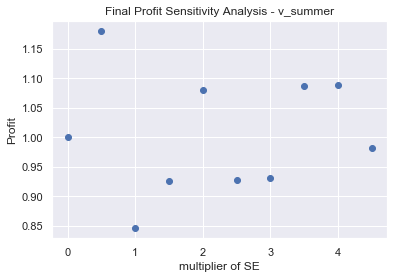

In [16]:
new_path(11, 10000)

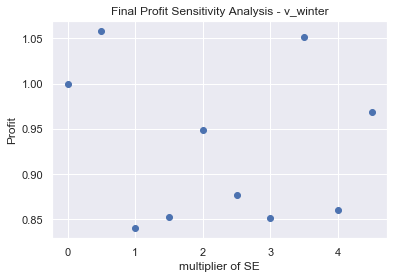

In [17]:
new_path(12, 10000)

In [19]:
np.arange(-3, 3.2, 0.2)

array([-3.00000000e+00, -2.80000000e+00, -2.60000000e+00, -2.40000000e+00,
       -2.20000000e+00, -2.00000000e+00, -1.80000000e+00, -1.60000000e+00,
       -1.40000000e+00, -1.20000000e+00, -1.00000000e+00, -8.00000000e-01,
       -6.00000000e-01, -4.00000000e-01, -2.00000000e-01,  2.66453526e-15,
        2.00000000e-01,  4.00000000e-01,  6.00000000e-01,  8.00000000e-01,
        1.00000000e+00,  1.20000000e+00,  1.40000000e+00,  1.60000000e+00,
        1.80000000e+00,  2.00000000e+00,  2.20000000e+00,  2.40000000e+00,
        2.60000000e+00,  2.80000000e+00,  3.00000000e+00])

In [22]:
np.arange(-3, 3.2, 0.2)[int(31 / 2)]

2.6645352591003757e-15

In [18]:
5/75 * 20

1.3333333333333333

In [16]:
from scipy.ndimage.filters import gaussian_filter

In [ ]:
gaussian_filter()